In [15]:
%load_ext autoreload
%autoreload 2

import os.path
import shutil
import time
import pdb

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable as V
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision

# from PIL import ImageFile
# ImageFile.LOAD_TRUNCATED_IMAGES = True

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import classification_report

%matplotlib inline

import util
import size_estimate
from logger import Logger
from plot_confusion_matrix import plot_conf_matrix

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Hyper Parameters

In [16]:
bs = 10 # Batch Size
learning_rate = 1e-4
wd = 0 # weight_decay
itr = 10
cuda = True
is_best = True
class_names = ['%d' % n for n in range(5)]

## Utils

In [17]:
if torch.cuda.is_available() and cuda:
    FloatType = torch.cuda.FloatTensor
    LongType = torch.cuda.LongTensor
else:
    FloatType = torch.FloatTensor
    LongType = torch.LongTensor

def to_np(x):
    return x.data.cpu().numpy()

def save_checkpoint(state, filename='checkpoint.pth.tar'):
    torch.save(state, filename)
    # if is_best:
    #    shutil.copyfile(filename, 'model_best.pth.tar')

def weights_init(m):
    if isinstance(m, nn.Conv2d):
        torch.nn.init.kaiming_normal_(m.weight.data)
    elif isinstance(m, nn.Linear):
        torch.nn.init.kaiming_normal_(m.weight.data)
        m.bias.data.normal_(mean=0,std=1e-2)
    elif isinstance(m, nn.BatchNorm2d):
        m.weight.data.uniform_()
        m.bias.data.zero_()

(512, 512, 3)


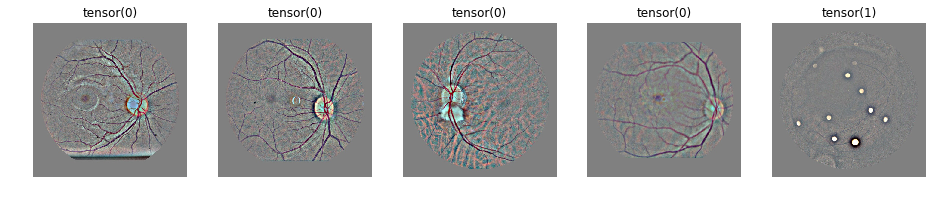

In [22]:
def get_train_valid_loader(
    data_dir, batch_size, augment,
    valid_size=0.1, shuffle=True, show_sample=False,
    num_workers=1, pin_memory=False
):
    """
    Utility function for loading and returning train and valid
    multi-process iterators over the CIFAR-10 dataset. A sample
    9x9 grid of the images can be optionally displayed.
    If using CUDA, num_workers should be set to 1 and pin_memory to True.
    Params
    ------
    - data_dir: path directory to the dataset.
    - batch_size: how many samples per batch to load.
    - augment: whether to apply the data augmentation scheme
      mentioned in the paper. Only applied on the train split.
    - random_seed: fix seed for reproducibility.
    - valid_size: percentage split of the training set used for
      the validation set. Should be a float in the range [0, 1].
    - shuffle: whether to shuffle the train/validation indices.
    - show_sample: plot 1x5 sample grid of the dataset.
    - num_workers: number of subprocesses to use when loading the dataset.
    - pin_memory: whether to copy tensors into CUDA pinned memory. Set it to
      True if using GPU.
    Returns
    -------
    - train_loader: training set iterator.
    - valid_loader: validation set iterator.
    """
    error_msg = "[!] valid_size should be in the range [0, 1]."
    assert ((valid_size >= 0) and (valid_size <= 1)), error_msg

    # define transforms
    valid_transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
    ])
    
    if augment:
        train_transform = torchvision.transforms.Compose([
            torchvision.transforms.RandomHorizontalFlip(),
            # torchvision.transforms.ColorJitter(brightness=0.1, contrast=0.4, saturation=0,4, hue=0.1),
            torchvision.transforms.ToTensor(),
        ])
    else:
        train_transform = torchvision.transforms.Compose([
            torchvision.transforms.ToTensor(),
        ])

    # load the dataset
    train_dataset = torchvision.datasets.ImageFolder(
        root = data_dir,
        transform=train_transform,
    )

    valid_dataset = torchvision.datasets.ImageFolder(
        root = data_dir, 
        transform=valid_transform,
    )

    num_train = len(train_dataset)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))

    if shuffle:
        np.random.shuffle(indices)

    train_idx, valid_idx = indices[split:][:5000], indices[:split][:1000]
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, sampler=train_sampler,
        num_workers=num_workers, pin_memory=pin_memory,
    )
    valid_loader = torch.utils.data.DataLoader(
        valid_dataset, batch_size=batch_size, sampler=valid_sampler,
        num_workers=num_workers, pin_memory=pin_memory,
    )

    # visualize some images
    if show_sample:
        num_sample = 5
        sample_loader = torch.utils.data.DataLoader(
            train_dataset, batch_size=num_sample, shuffle=shuffle,
            num_workers=num_workers, pin_memory=pin_memory,
        )
        data_iter = iter(sample_loader)
        images, labels = data_iter.next()
        X = images.numpy().transpose([0, 2, 3, 1])
        print(X[0].shape)
        fig, ax = plt.subplots(1, num_sample, figsize = (16, 4))
        for n in range(num_sample):
            ax[n].set_axis_off()
            ax[n].imshow(X[n])
            ax[n].set_title(labels[n])
    return (train_loader, valid_loader)

# Loading dataset
data_dir = util.dataset_base+"/preprocess/train_filter"
train_loader, valid_loader = get_train_valid_loader(
    data_dir, batch_size=bs, augment=False,
    valid_size=0.1, shuffle=True, show_sample=True,
    num_workers=4, pin_memory=True
)

In [19]:
# Model and Optimizer definition
logger = Logger('./logs')
model = torchvision.models.resnet34(pretrained = True)
in_features = model.fc.in_features
num_class = len(train_loader.dataset.classes)
model.avgpool = nn.AvgPool2d(10,10)
model.fc = nn.Linear(in_features, num_class)

model = torch.nn.DataParallel(model, device_ids=[0])

if cuda:
    model = model.cuda()

model.module.fc.apply(weights_init)

optimizer = optim.Adam(params = model.parameters(), lr = learning_rate, weight_decay=wd)
criterion = torch.nn.CrossEntropyLoss(FloatType([ 1.3568521, 15.38461538, 6.62251656, 52.63157895, 35.71428571]))

resume_path = None
if resume_path:
    if os.path.isfile(resume_path):
        print("=> loading checkpoint '{}'".format(resume_path))
        checkpoint = torch.load(resume_path)
        start_epoch = checkpoint['epoch']
        model.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        print("=> loaded checkpoint '{}' (epoch {})"
              .format(resume_path, checkpoint['epoch']))
    else:
        print("=> no checkpoint found at '{}'".format(resume_path))

In [20]:
def train_model(model, optimizer, train_loader, criterion, epoch, vis_step):
    batch_time = util.AverageMeter()
    data_time = util.AverageMeter()
    
    model.train()
    num_hit = 0.0
    # Training Phase on train dataset
    
    end = time.time()
    for batch_idx, (image, labels) in enumerate(train_loader):
        data_time.update(time.time() - end)
        
        if torch.cuda.is_available() and cuda:
            image = image.cuda()
            labels = labels.cuda()
        output = model(image)
        loss = criterion(output, labels)
        
        with torch.no_grad():
            _ , pred_label = output.data.max(dim=1)
            curr_hit = (pred_label == labels).sum().item()
            num_hit += curr_hit

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        batch_time.update(time.time() - end)
        end = time.time()
        
        if batch_idx % vis_step == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
                'Loss {loss:.6f}\t'
                'Acc {acc:.3f}'.format(
                epoch, batch_idx, len(train_loader), batch_time=batch_time,
                data_time=data_time, loss=loss.data[0], acc=(curr_hit/train_loader.batch_size)))

    train_accuracy = (num_hit /(len(train_loader) * len(image)))
    print("Epoch: {}, Training Accuracy: {:.2f}%".format(epoch, 100. * train_accuracy))
    save_checkpoint({
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'optimizer' : optimizer.state_dict(),
            })

    info = {
            'loss_train':train_accuracy,
        }

    for tag, value in info.items():
        logger.scalar_summary(tag, value, epoch)
    for tag, value in model.named_parameters():
        tag = tag.replace('.', '/')
        logger.histo_summary(tag, to_np(value), epoch)
        logger.histo_summary(tag+'/grad', to_np(value.grad), epoch)
    return 100. * train_accuracy

def eval_model(model, test_loader, epoch, vis_step):
    batch_time = util.AverageMeter()

    model.eval()
    num_hit = 0.0
    
    with torch.no_grad():
        end = time.time()
        for batch_idx, (image, labels) in enumerate(test_loader):
            if torch.cuda.is_available() and cuda:
                image = image.cuda()
                labels = labels.cuda()
            output = model(image)
            loss = criterion(output, labels)
            
            _ , pred_label = output.data.max(dim=1)
            curr_hit = (pred_label == labels).sum().item()
            num_hit += curr_hit
            true.extend(labels.data.cpu().numpy().tolist())
            pred.extend(pred_label.cpu().numpy().tolist())

            
            batch_time.update(time.time() - end)
            end = time.time()

            if batch_idx % vis_step == 0:
                print('Epoch: [{0}][{1}/{2}]\t'
                    'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                    'Loss {loss:.6f}\t'
                    'Acc {acc:.3f}'.format(
                    epoch, batch_idx, len(test_loader), batch_time=batch_time,
                    loss=loss.data[0], acc=(curr_hit/test_loader.batch_size)))
            
        test_accuracy = (num_hit / (len(test_loader) * len(image)))
        print("Epoch: {}, Testing Accuracy: {:.2f}%".format(epoch, 100. * test_accuracy))
        info = {
                'loss_test':test_accuracy,
            }

        for tag, value in info.items():
            logger.scalar_summary(tag, value, epoch)
    return 100. * test_accuracy

C:\Users\Chiraag\Anaconda3\envs\gazelle\lib\site-packages\ipykernel_launcher.py:38: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch: [0][0/500]	Time 1.931 (1.931)	Data 1.697 (1.697)	Loss 1.672582	Acc 0.400
Epoch: [0][10/500]	Time 0.384 (0.529)	Data 0.000 (0.173)	Loss 1.330527	Acc 0.500
Epoch: [0][20/500]	Time 0.394 (0.462)	Data 0.000 (0.100)	Loss 1.069262	Acc 0.500
Epoch: [0][30/500]	Time 0.395 (0.438)	Data 0.000 (0.073)	Loss 2.895081	Acc 0.400
Epoch: [0][40/500]	Time 0.390 (0.426)	Data 0.000 (0.060)	Loss 3.787023	Acc 0.500
Epoch: [0][50/500]	Time 0.390 (0.418)	Data 0.000 (0.052)	Loss 0.976274	Acc 0.300
Epoch: [0][60/500]	Time 0.381 (0.413)	Data 0.000 (0.047)	Loss 1.292025	Acc 0.300
Epoch: [0][70/500]	Time 0.390 (0.410)	Data 0.000 (0.043)	Loss 0.570919	Acc 0.600
Epoch: [0][80/500]	Time 0.383 (0.407)	Data 0.000 (0.040)	Loss 1.137422	Acc 0.300
Epoch: [0][90/500]	Time 0.389 (0.405)	Data 0.000 (0.037)	Loss 0.849534	Acc 0.700
Epoch: [0][100/500]	Time 0.374 (0.404)	Data 0.000 (0.035)	Loss 1.192449	Acc 0.600
Epoch: [0][110/500]	Time 0.377 (0.403)	Data 0.000 (0.034)	Loss 1.583656	Acc 0.600
Epoch: [0][120/500]	Time 0.

C:\Users\Chiraag\Anaconda3\envs\gazelle\lib\site-packages\ipykernel_launcher.py:91: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch: [0][0/100]	Time 1.860 (1.860)	Loss 0.884857	Acc 0.600
Epoch: [0][10/100]	Time 0.097 (0.262)	Loss 2.866463	Acc 0.600
Epoch: [0][20/100]	Time 0.090 (0.185)	Loss 2.222107	Acc 0.400
Epoch: [0][30/100]	Time 0.101 (0.158)	Loss 0.709942	Acc 0.600
Epoch: [0][40/100]	Time 0.111 (0.144)	Loss 0.945214	Acc 0.500
Epoch: [0][50/100]	Time 0.094 (0.135)	Loss 0.878942	Acc 0.700
Epoch: [0][60/100]	Time 0.107 (0.130)	Loss 1.393698	Acc 0.400
Epoch: [0][70/100]	Time 0.105 (0.125)	Loss 1.110199	Acc 0.500
Epoch: [0][80/100]	Time 0.099 (0.122)	Loss 0.886606	Acc 0.700
Epoch: [0][90/100]	Time 0.100 (0.120)	Loss 1.180742	Acc 0.700
Epoch: 0, Testing Accuracy: 56.00%
CCR = 0.56
Confusion matrix, without normalization
[[448  93 202   0   3]
 [ 26   9  24   0   1]
 [ 32   9  93   0  15]
 [  1   0  16   1  10]
 [  0   0   8   0   9]]
Normalized confusion matrix
[[0.6  0.12 0.27 0.   0.  ]
 [0.43 0.15 0.4  0.   0.02]
 [0.21 0.06 0.62 0.   0.1 ]
 [0.04 0.   0.57 0.04 0.36]
 [0.   0.   0.47 0.   0.53]]


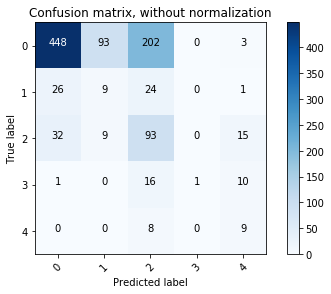

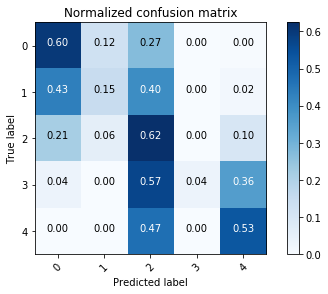

              precision    recall  f1-score   support

     class 0       0.88      0.60      0.72       746
     class 1       0.08      0.15      0.11        60
     class 2       0.27      0.62      0.38       149
     class 3       1.00      0.04      0.07        28
     class 4       0.24      0.53      0.33        17

   micro avg       0.56      0.56      0.56      1000
   macro avg       0.49      0.39      0.32      1000
weighted avg       0.74      0.56      0.60      1000

Epoch: [1][0/500]	Time 2.014 (2.014)	Data 1.784 (1.784)	Loss 1.336720	Acc 0.400
Epoch: [1][10/500]	Time 0.400 (0.542)	Data 0.000 (0.180)	Loss 1.545760	Acc 0.900
Epoch: [1][20/500]	Time 0.399 (0.472)	Data 0.000 (0.103)	Loss 0.407547	Acc 0.700
Epoch: [1][30/500]	Time 0.400 (0.447)	Data 0.000 (0.076)	Loss 0.910033	Acc 0.900
Epoch: [1][40/500]	Time 0.392 (0.434)	Data 0.000 (0.062)	Loss 0.991562	Acc 0.700
Epoch: [1][50/500]	Time 0.405 (0.427)	Data 0.000 (0.054)	Loss 1.198046	Acc 0.800
Epoch: [1][60/500]	Time 0.

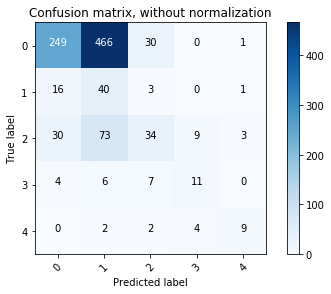

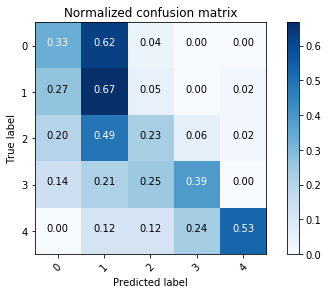

              precision    recall  f1-score   support

     class 0       0.83      0.33      0.48       746
     class 1       0.07      0.67      0.12        60
     class 2       0.45      0.23      0.30       149
     class 3       0.46      0.39      0.42        28
     class 4       0.64      0.53      0.58        17

   micro avg       0.34      0.34      0.34      1000
   macro avg       0.49      0.43      0.38      1000
weighted avg       0.72      0.34      0.43      1000

Epoch: [2][0/500]	Time 2.030 (2.030)	Data 1.798 (1.798)	Loss 1.236733	Acc 0.400
Epoch: [2][10/500]	Time 0.389 (0.543)	Data 0.000 (0.180)	Loss 0.823031	Acc 0.700
Epoch: [2][20/500]	Time 0.385 (0.474)	Data 0.000 (0.103)	Loss 0.960972	Acc 0.700
Epoch: [2][30/500]	Time 0.397 (0.451)	Data 0.000 (0.076)	Loss 0.433767	Acc 0.900
Epoch: [2][40/500]	Time 0.408 (0.439)	Data 0.000 (0.062)	Loss 0.695156	Acc 0.700
Epoch: [2][50/500]	Time 0.393 (0.430)	Data 0.000 (0.054)	Loss 1.115489	Acc 0.600
Epoch: [2][60/500]	Time 0.

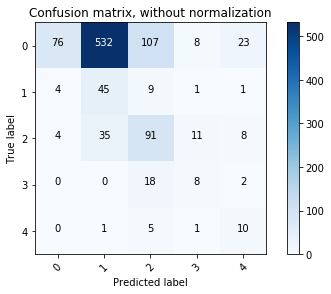

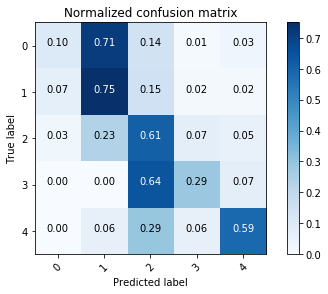

              precision    recall  f1-score   support

     class 0       0.90      0.10      0.18       746
     class 1       0.07      0.75      0.13        60
     class 2       0.40      0.61      0.48       149
     class 3       0.28      0.29      0.28        28
     class 4       0.23      0.59      0.33        17

   micro avg       0.23      0.23      0.23      1000
   macro avg       0.38      0.47      0.28      1000
weighted avg       0.75      0.23      0.23      1000

Epoch: [3][0/500]	Time 2.243 (2.243)	Data 2.009 (2.009)	Loss 0.196536	Acc 0.700
Epoch: [3][10/500]	Time 0.406 (0.564)	Data 0.000 (0.200)	Loss 0.528777	Acc 0.500
Epoch: [3][20/500]	Time 0.373 (0.486)	Data 0.000 (0.114)	Loss 0.791119	Acc 0.800
Epoch: [3][30/500]	Time 0.382 (0.457)	Data 0.000 (0.084)	Loss 0.772476	Acc 0.700
Epoch: [3][40/500]	Time 0.404 (0.442)	Data 0.000 (0.068)	Loss 0.543782	Acc 0.700
Epoch: [3][50/500]	Time 0.410 (0.433)	Data 0.000 (0.058)	Loss 0.749270	Acc 0.500
Epoch: [3][60/500]	Time 0.

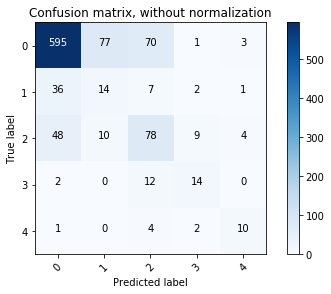

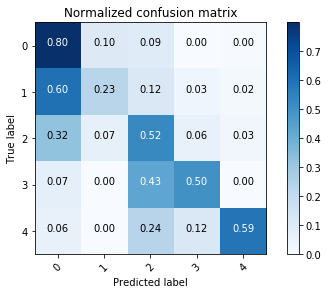

              precision    recall  f1-score   support

     class 0       0.87      0.80      0.83       746
     class 1       0.14      0.23      0.17        60
     class 2       0.46      0.52      0.49       149
     class 3       0.50      0.50      0.50        28
     class 4       0.56      0.59      0.57        17

   micro avg       0.71      0.71      0.71      1000
   macro avg       0.50      0.53      0.51      1000
weighted avg       0.75      0.71      0.73      1000

Epoch: [4][0/500]	Time 1.972 (1.972)	Data 1.745 (1.745)	Loss 0.567709	Acc 0.800
Epoch: [4][10/500]	Time 0.409 (0.541)	Data 0.000 (0.178)	Loss 0.310146	Acc 0.900
Epoch: [4][20/500]	Time 0.406 (0.472)	Data 0.000 (0.102)	Loss 0.522790	Acc 0.800
Epoch: [4][30/500]	Time 0.404 (0.448)	Data 0.000 (0.075)	Loss 0.404579	Acc 0.900
Epoch: [4][40/500]	Time 0.407 (0.436)	Data 0.000 (0.061)	Loss 0.353358	Acc 0.900
Epoch: [4][50/500]	Time 0.391 (0.428)	Data 0.000 (0.053)	Loss 0.474038	Acc 0.600
Epoch: [4][60/500]	Time 0.

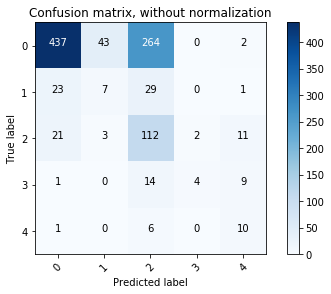

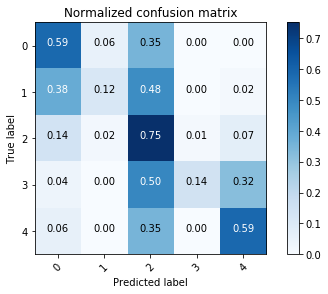

              precision    recall  f1-score   support

     class 0       0.90      0.59      0.71       746
     class 1       0.13      0.12      0.12        60
     class 2       0.26      0.75      0.39       149
     class 3       0.67      0.14      0.24        28
     class 4       0.30      0.59      0.40        17

   micro avg       0.57      0.57      0.57      1000
   macro avg       0.45      0.44      0.37      1000
weighted avg       0.75      0.57      0.61      1000

Epoch: [5][0/500]	Time 1.935 (1.935)	Data 1.701 (1.701)	Loss 0.078010	Acc 1.000
Epoch: [5][10/500]	Time 0.404 (0.536)	Data 0.000 (0.172)	Loss 0.070527	Acc 0.800
Epoch: [5][20/500]	Time 0.403 (0.470)	Data 0.000 (0.100)	Loss 0.146430	Acc 1.000
Epoch: [5][30/500]	Time 0.406 (0.447)	Data 0.000 (0.073)	Loss 0.060917	Acc 1.000
Epoch: [5][40/500]	Time 0.406 (0.436)	Data 0.000 (0.060)	Loss 0.048828	Acc 1.000
Epoch: [5][50/500]	Time 0.411 (0.428)	Data 0.000 (0.053)	Loss 0.147817	Acc 1.000
Epoch: [5][60/500]	Time 0.

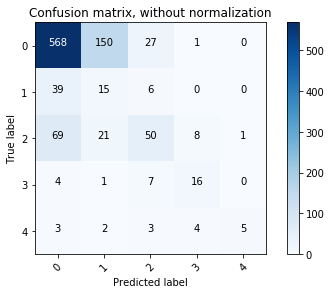

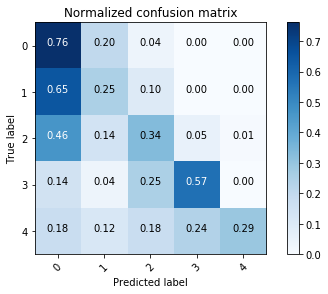

              precision    recall  f1-score   support

     class 0       0.83      0.76      0.79       746
     class 1       0.08      0.25      0.12        60
     class 2       0.54      0.34      0.41       149
     class 3       0.55      0.57      0.56        28
     class 4       0.83      0.29      0.43        17

   micro avg       0.65      0.65      0.65      1000
   macro avg       0.57      0.44      0.46      1000
weighted avg       0.73      0.65      0.68      1000

Epoch: [6][0/500]	Time 1.939 (1.939)	Data 1.708 (1.708)	Loss 0.269109	Acc 0.900
Epoch: [6][10/500]	Time 0.400 (0.536)	Data 0.000 (0.172)	Loss 0.064394	Acc 0.800
Epoch: [6][20/500]	Time 0.402 (0.470)	Data 0.000 (0.099)	Loss 0.137533	Acc 1.000
Epoch: [6][30/500]	Time 0.403 (0.448)	Data 0.000 (0.074)	Loss 0.068810	Acc 0.900
Epoch: [6][40/500]	Time 0.407 (0.437)	Data 0.000 (0.060)	Loss 0.275366	Acc 0.900
Epoch: [6][50/500]	Time 0.402 (0.430)	Data 0.000 (0.052)	Loss 0.220549	Acc 0.800
Epoch: [6][60/500]	Time 0.

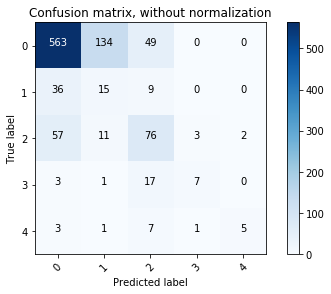

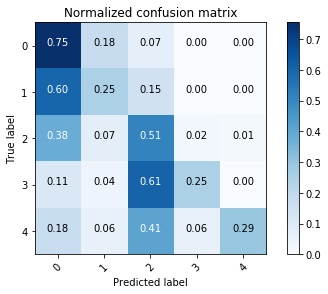

              precision    recall  f1-score   support

     class 0       0.85      0.75      0.80       746
     class 1       0.09      0.25      0.14        60
     class 2       0.48      0.51      0.50       149
     class 3       0.64      0.25      0.36        28
     class 4       0.71      0.29      0.42        17

   micro avg       0.67      0.67      0.67      1000
   macro avg       0.55      0.41      0.44      1000
weighted avg       0.74      0.67      0.70      1000

Epoch: [7][0/500]	Time 2.052 (2.052)	Data 1.825 (1.825)	Loss 0.055930	Acc 0.900
Epoch: [7][10/500]	Time 0.393 (0.550)	Data 0.000 (0.183)	Loss 0.158447	Acc 0.900
Epoch: [7][20/500]	Time 0.401 (0.479)	Data 0.000 (0.105)	Loss 0.065476	Acc 1.000
Epoch: [7][30/500]	Time 0.399 (0.454)	Data 0.000 (0.077)	Loss 0.017536	Acc 1.000
Epoch: [7][40/500]	Time 0.403 (0.442)	Data 0.000 (0.063)	Loss 0.016580	Acc 1.000
Epoch: [7][50/500]	Time 0.399 (0.433)	Data 0.000 (0.055)	Loss 0.134533	Acc 1.000
Epoch: [7][60/500]	Time 0.

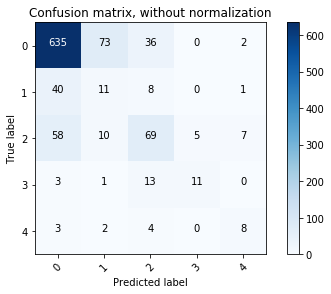

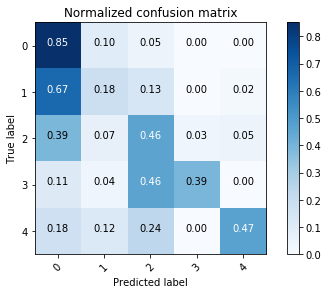

              precision    recall  f1-score   support

     class 0       0.86      0.85      0.86       746
     class 1       0.11      0.18      0.14        60
     class 2       0.53      0.46      0.49       149
     class 3       0.69      0.39      0.50        28
     class 4       0.44      0.47      0.46        17

   micro avg       0.73      0.73      0.73      1000
   macro avg       0.53      0.47      0.49      1000
weighted avg       0.75      0.73      0.74      1000

Epoch: [8][0/500]	Time 1.966 (1.966)	Data 1.732 (1.732)	Loss 0.154678	Acc 0.800
Epoch: [8][10/500]	Time 0.402 (0.541)	Data 0.000 (0.175)	Loss 0.117297	Acc 0.900
Epoch: [8][20/500]	Time 0.410 (0.474)	Data 0.000 (0.101)	Loss 0.387686	Acc 0.900
Epoch: [8][30/500]	Time 0.393 (0.449)	Data 0.000 (0.074)	Loss 0.059832	Acc 0.900
Epoch: [8][40/500]	Time 0.406 (0.437)	Data 0.000 (0.061)	Loss 0.042418	Acc 1.000
Epoch: [8][50/500]	Time 0.391 (0.429)	Data 0.000 (0.052)	Loss 0.318542	Acc 0.900
Epoch: [8][60/500]	Time 0.

In [ ]:
train_acc = []
test_acc = []
best_accuracy = 0
for epoch in range(itr):
    true = []
    pred = []
    tr_acc = train_model(model, optimizer, train_loader, criterion, epoch, 10)
    ts_acc = eval_model(model, valid_loader, epoch, 10)
    # train_acc.append(tr_acc)
    # test_acc.append(ts_acc)
    # pdb.set_trace()
    plot_conf_matrix(true, pred, class_names)
    # print("cohen kapa score:",cohen_kappa_score(true, pred))
    target_names = ['class %d' % n for n in range(5)]
    print(classification_report(true, pred, target_names=target_names))

In [ ]:
model = torchvision.models.resnet34(pretrained = True)
in_features = model.fc.in_features
num_class = 5 # len(train_loader.dataset.classes)
model.avgpool = nn.AvgPool2d(10,10)
model.fc = nn.Linear(in_features, num_class)

# model = torch.nn.DataParallel(model, device_ids=[0])

if cuda:
    model = model.cuda()

# model.module.fc.apply(weights_init)
se = size_estimate.summary(model, input_size=(3,512,512), batch_size=10)

In [ ]:
FloatType([9,25])

In [ ]:
bin_count = np.zeros((2, 5))

for idx, (image, labels) in enumerate(train_loader):
    bin_count[0] += np.bincount(labels.numpy(), minlength=5)
    
for idx, (image, labels) in enumerate(valid_loader):
    bin_count[1] += np.bincount(labels.numpy(), minlength=5)

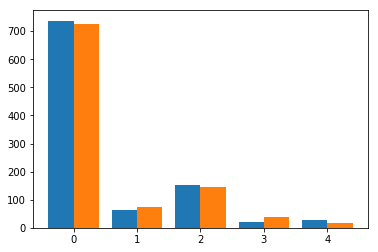

In [18]:
plt.bar(np.arange(5)-0.2, bin_count[0], 0.4)
plt.bar(np.arange(5)+0.2, bin_count[1], 0.4)
plt.show()

In [22]:
print(bin_count[0])
print(1/bin_count[0]*np.sum(bin_count[0]))

[737.  65. 151.  19.  28.]
[ 1.3568521  15.38461538  6.62251656 52.63157895 35.71428571]


In [28]:
print(bin_count[0][0], np.sum(bin_count[0][1:]))
print(np.sum(bin_count[0])/bin_count[0][0]*7, np.sum(bin_count[0])/np.sum(bin_count[0][1:])*7)

737.0 263.0
9.49796472184532 26.61596958174905
